## Fine-tuning torchvision models

### Tutorial from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import time
import os
import random
import copy
from PIL import Image
from torch.utils.data import Dataset
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.15.0a0+9b233d4


In [2]:
# Model parameters
batch_size=32
num_classes = 2
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

### Define a few helper functions

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # phase = "train"
        # model.train()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # # Iterate over data.
            # for inputs, labels in dataloaders:
            #     inputs = inputs.to(device)
            #     labels = labels.to(device)
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # epoch_loss = running_loss / len(dataloaders.dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders.dataset)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    """ Inception v3
    Be careful, expects (299,299) sized images and has auxiliary output
    """
    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Need to reshape both the primary output layer and the auxiliary output layer
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 299

    return model_ft, input_size

In [5]:
# Split image folders into train, val, test
def split_data(patch_directory, split: list, seed):
    '''
    Function that takes in the split percentage for train/val/test sets, and randomly chooses which cases
    to allocate to which set (to ensure all patches from one case go into one set)
    Parameters:
    patch_directory: folder containing all patches
    split: list of integers for splitting sets
    seed: option to set the seed value for randomness
    Returns:
    3 lists for each of train/val/test, where each list contains the case names to be used in the set
    '''
    
    random.seed(seed)

    case_folders = os.listdir(patch_directory) # get 147 case folders
    
    d = {}
    for folder in case_folders:
        num_patches_in_folder = len(os.listdir(patch_directory + folder))
        d[folder] = num_patches_in_folder
    
    total_num_patches = sum(d.values())
    train_split, val_split, test_split = split
    train_num_patches = int((train_split/100)*total_num_patches)
    val_num_patches = int((val_split/100)*total_num_patches)

    # list all folders in the directory
    folders = [os.path.join(patch_directory, folder) for folder in os.listdir(patch_directory) if os.path.isdir(os.path.join(patch_directory, folder))]
    
    # SELECT TRAINING CASES
    train_cases = [] # store all selected cases
    num_selected_train = 0 # number of patches selected so far
    selected_folders = set() # a set to store the selected folder names to keep track of those already selected
    while num_selected_train < train_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_train += num_patches
            selected_folders.add(folder) # add to set of selected folders
            train_cases.append(case)

    # SELECT VAL CASES
    val_cases = [] # store all selected cases
    num_selected_val = 0 # number of patches selected so far
    while num_selected_val < val_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_val += num_patches
            selected_folders.add(folder)
            val_cases.append(case)

    # SELECT TEST CASES
    cases = [folder.replace(patch_directory, '') for folder in folders]
    used = train_cases+val_cases
    test_cases = [case for case in cases if case not in used]
    
    # test_patches = [len(os.listdir(patch_directory + folder)) for folder in test_cases]
    num_selected_test = sum([len(os.listdir(patch_directory + folder)) for folder in test_cases])
    # dict = {x: for x in ['train', 'val', 'test']}
    print(f"Number of training patches: {num_selected_train} \nNumber of validation patches {num_selected_val} \nNumber of test patches {num_selected_test}")
    return train_cases, val_cases, test_cases

In [79]:
# Create a custom PyTorch dataset to read in your images and apply transforms

class CustomDataset(Dataset):
    def __init__(self, img_folders, label_files, transform=None):
        self.img_folders = img_folders
        self.label_files = label_files
        self.transform = transform

        self.imgs = [] # Keeps image paths to load in the __getitem__ method
        self.labels = []

        # Load images and corresponding labels
        for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
            # print("Patch directory", img_folder, "\nLabel file", label_file)
            labels_pt = torch.load(label_file) # Load .pt file
            # Run through all patches from the case folder
            for i, img in enumerate(os.listdir(img_folder)):
                if os.path.isfile(img_folder + '/' + img) and os.path.isfile(label_file):
                    # print(img_folder + img)
                    idx = img.replace('.png', '').split("_")[1]
                    self.imgs.append(img_folder + '/' + img)
                    self.labels.append(labels_pt[idx].item()) # get label as int
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # Load image at given index
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None: # Apply transformations
            image = self.transform(image)
        
        label = self.labels[idx] # Load corresponding image label
        
        return image, label # Return transformed image and label

In [7]:
PATCH_SIZE=256
STRIDE=PATCH_SIZE
split=[70, 15, 15] # for splitting into train/val/test
SEED = 42

In [8]:
dir = '/Volumes/AlexS/MastersData/processed/patches/'
train_cases, val_cases, test_cases = split_data(dir, split, SEED)

Number of training patches: 261925 
Number of validation patches 56191 
Number of test patches 53024


In [9]:
# Check function
print(len(train_cases + val_cases + test_cases) == 147)

True


In [10]:
# Initialise data transforms
INPUT_SIZE=299 ### InceptionV3 takes in 299x299 as input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [80]:
# TESTING CUSTOM DATASET ON VERY LIMITED DATA (for memory issues)
img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

cases = ['A2-A0CX', 'A2-A0SW']
img_folders = [img_dir + case for case in cases]
label_folders = [labels_dir + case + '.pt' for case in cases]

test_dataset = CustomDataset(img_folders, label_folders, transform=data_transforms['train'])
print(len(test_dataset))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Directories for PATCHES
img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

train_img_folders = [img_dir + case for case in train_cases]
val_img_folders = [img_dir + case for case in val_cases]
test_img_folders = [img_dir + case for case in test_cases]

# Contains the file path for each .pt file for the cases used in each of the sets
train_labels = [labels_dir + case + '.pt' for case in train_cases]
val_labels = [labels_dir + case + '.pt' for case in val_cases]
test_labels = [labels_dir + case + '.pt' for case in test_cases]

image_datasets = {
    'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
    'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
}
# Create training, validation and test dataloaders
dataloaders = {
    'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
    'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

In [39]:
# WORK WITH SMALL SAMPLE OF DATA
img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

split=[3, 1.5, 1.5]
train_cases, val_cases, test_cases = split_data(dir, split, SEED)

train_img_folders = [img_dir + case for case in train_cases]
val_img_folders = [img_dir + case for case in val_cases]

print(train_img_folders)

# Contains the file path for each .pt file for the cases used in each of the sets
train_labels = [labels_dir + case + '.pt' for case in train_cases]
val_labels = [labels_dir + case + '.pt' for case in val_cases]

image_datasets = {
    'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val'])
}
# Create training, validation and test dataloaders
dataloaders = {
    'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True)
}

Number of training patches: 14047 
Number of validation patches 6220 
Number of test patches 350873
['/Volumes/AlexS/MastersData/processed/patches/AC-A23C', '/Volumes/AlexS/MastersData/processed/patches/A2-A0SY', '/Volumes/AlexS/MastersData/processed/patches/BH-A0BF', '/Volumes/AlexS/MastersData/processed/patches/B6-A0WV']


In [37]:
dataset = image_datasets['train']
print(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


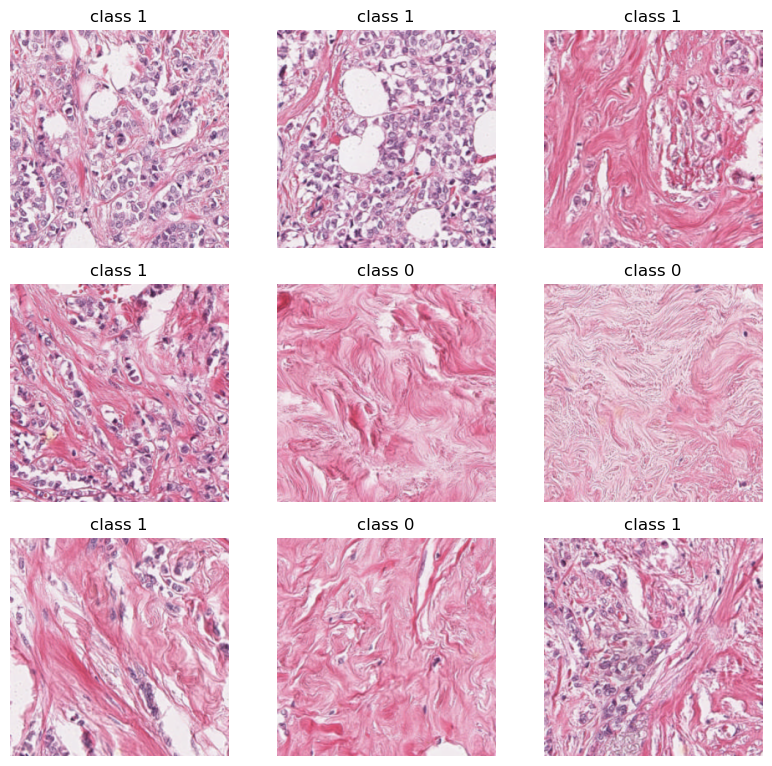

In [76]:
# Visualise some examples to check custom class is working
import matplotlib.pyplot as plt

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

fig = plt.figure(figsize=(8, 8))

for i in range(len(dataset)):
    
    sample = dataset[1900+ 80*i]

    # print(i, sample[0].shape, sample[1])

    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title(f'class {sample[1]}')
    ax.axis('off')
    img = np.transpose(sample[0].numpy(), (1, 2, 0))
    # img = img.astype('float') / np.max(img)
    img = img * std + mean
    # print(np.min(img), np.max(img))
    plt.imshow(img)
    if i == 8:
        plt.show()
        break

In [13]:
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [16]:
# Observe that all parameters are being optimized
optimizer_ft = optim.RMSprop(params_to_update, lr=0.1, weight_decay=0.9, momentum=0.9, eps=1.0)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=True)

Epoch 0/14
----------


KeyboardInterrupt: 

Look at data used in tutorial

In [ ]:
data_dir = "/Users/alexandrasmith/Downloads/hymenoptera_data"

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [ ]:
tr = dataloaders_dict['train']
val = dataloaders_dict['val']

train_features, train_labels = next(iter(tr))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

In [ ]:
print(len(tr.dataset))
print(len(val.dataset))

In [ ]:
print(len(tr))